In [11]:
import numpy as np
import pandas as pd
from astropy.table import Table
import ML_util
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
meta_clean = ML_util.read_and_clean()
meta_clean.head()

,strehl,fwhm,airmass,az,MASS,DIMM,wind_speed,wind_direction,temperature,relative_humidity,pressure
1643,0.331,59.09,1.55908,166.16518,0.06,0.40,0.514444,119.0,3.52,48.0,0.6182
1644,0.312,61.04,1.55759,166.39213,0.06,0.40,0.514444,119.0,3.52,48.0,0.6182
1645,0.316,57.67,1.55611,166.62168,0.06,0.45,0.514444,119.0,3.50,47.0,0.6182
1646,0.238,73.30,1.55465,166.85421,0.06,0.45,1.028889,119.0,3.47,47.0,0.6183
1647,0.269,65.81,1.55310,167.10523,0.06,0.42,0.514444,120.0,3.45,50.0,0.6183


In [3]:
X = meta_clean[ML_util.use_cols[2:]]
strehl = meta_clean[ML_util.use_cols[0]]
fwhm = meta_clean[ML_util.use_cols[1]]

In [4]:
### Scale the data
# StandardScaler() subtracts the mean and divides by the standard deviation
# Very important for PCA to normalize for high-magnitude features

In [5]:
y = strehl
train_X, test_X, train_y, test_y = train_test_split(X, y)
s = StandardScaler(with_std=False)
s.fit(train_X)
train_X = s.transform(train_X)
test_X = s.transform(test_X)

# (1-tolerance) is the amount (%) of variation we keep in our data
tolerance = 0.01

### Basic PCA - extracts features which have the most variation in the data
pca = PCA(1-tolerance)
#pca = PCA(n_components=3)
pca.fit(train_X)
#train_X = pca.transform(train_X)
#test_X = pca.transform(test_X)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [6]:
y = strehl
train_X, test_X, train_y, test_y = ML_util.split_and_scale(X, y)
#train_X, test_X = ML_util.run_PCA(train_X, test_X, 0.01)

In [9]:
svm = SVR(gamma='scale', C=0.2, coef0=1, degree=3, kernel='poly')
svm.fit(train_X, train_y)

train_pred = svm.predict(train_X)
test_pred = svm.predict(test_X)

train_err = mean_absolute_error(train_pred, train_y)
test_err = mean_absolute_error(test_pred, test_y)
train_mape = np.abs((train_pred-train_y)/train_y)
test_mape = np.abs((test_pred-test_y)/test_y)

print("Training error:", train_err, "\nTesting error:", test_err)
print("Training MAPE:", np.mean(train_mape), "\nTesting MAPE:", np.mean(test_mape))

Training error: 0.041692448308078396 
Testing error: 0.04185605683985953
Training MAPE: 0.17669230499733124 
Testing MAPE: 0.17077398288050938


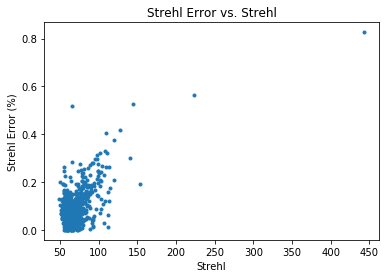

In [21]:
plt.plot(test_y, test_mape, '.')
plt.title("Strehl Error vs. Strehl")
plt.xlabel("Strehl")
plt.ylabel("Strehl Error (%)")
#plt.savefig("plots/"+"SVR_strehl.png")

In [15]:
y = fwhm
train_X, test_X, train_y, test_y = ML_util.split_and_scale(X, y)

In [16]:
svm = SVR(gamma='scale', C=0.2, coef0=1, degree=3, kernel='poly')
svm.fit(train_X, train_y)

train_pred = svm.predict(train_X)
test_pred = svm.predict(test_X)

train_err = mean_absolute_error(train_pred, train_y)
test_err = mean_absolute_error(test_pred, test_y)
train_mape = np.abs((train_pred-train_y)/train_y)
test_mape = np.abs((test_pred-test_y)/test_y)

print("Training error:", train_err, "\nTesting error:", test_err)
print("Training MAPE:", np.mean(train_mape), "\nTesting MAPE:", np.mean(test_mape))

Training error: 6.390119624737302 
Testing error: 6.568339626762449
Training MAPE: 0.08117640480767363 
Testing MAPE: 0.0823482996133299


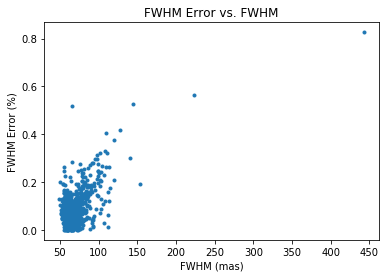

In [22]:
plt.plot(test_y, test_mape, '.')
plt.title("FWHM Error vs. FWHM")
plt.xlabel("FWHM (mas)")
plt.ylabel("FWHM Error (%)")
#plt.savefig("plots/"+"SVR_fwhm.png")

In [17]:
params = {'kernel': ['poly'], 'degree':range(1, 10), 
          'coef0':[1], 'C':[x for x in np.arange(0.1,5,0.1)], 'gamma':['scale']}

svm = SVR()
search = GridSearchCV(svm, params, cv=5, scoring="neg_mean_absolute_error")
search.fit(train_X, train_y)

train_pred = search.predict(train_X)
test_pred = search.predict(test_X)

train_err = mean_absolute_error(train_pred, train_y)
test_err = mean_absolute_error(test_pred, test_y)

print("Training error:", train_err, "\nTesting error:", test_err)
print("Training error over mean:", train_err/np.mean(train_y), "\nTesting error over mean:", test_err/np.mean(train_y))

Training error: 0.04128995674188396 
Testing error: 0.04264101310142973
Training error over mean: 0.14938907082777841 
Testing error over mean: 0.15427725841901815


In [18]:
best = search.best_estimator_
params = search.best_params_
params

{'C': 0.2, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}

In [1]:
# OK, so idk if a 10th degree polynomial is really the best thing to estimate with, but I did use 5-fold CV
# So hopefully it's fine